In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time

from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split
%matplotlib inline

/Users/lana/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1.Load Dataset

In [2]:
from keras.datasets import imdb

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

In [4]:
print(x_train.shape, 'train sequences')
print(x_test.shape, 'test sequences')

(25000,) train sequences
(25000,) test sequences


## 2. Neural Network

#### Preprocessing 

max:  2494
min:  11
average:  238.71364
Standard Deviation: 176.4937


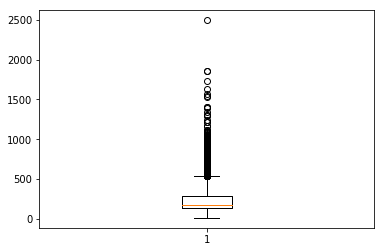

In [5]:
l=[len(i) for i in x_train]
print('max: ',max(l))
print('min: ',min(l))
print('average: ',sum(l)/len(l))
print('Standard Deviation: {:.4f}'.format(np.std(l)))
plt.boxplot(l)
plt.show()

* Therefore, most of the reviews have within 500 words

In [6]:
x_train_pad = sequence.pad_sequences(x_train, maxlen=500)
x_test_pad = sequence.pad_sequences(x_test, maxlen=500)

In [7]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train_pad, y_train, random_state=10)

## 2.1. LSTM

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [42]:
lstm = Sequential()
lstm.add(Embedding(20000, 128, input_length=500))

lstm.add(Dropout(0.2))
lstm.add(LSTM(100))
lstm.add(Dropout(0.2))

lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 2,651,701
Trainable params: 2,651,701
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [44]:
start_time_lstm=time.time()
lstm_history = lstm.fit(Xtrain, ytrain, 
          nb_epoch=10, batch_size=64,
          validation_data=(Xvalid, yvalid),
       callbacks=callback)
end_time_lstm=time.time()
print(end_time_lstm-start_time_lstm)

/Users/lana/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 587s 31ms/step - loss: 0.4740 - acc: 0.7676 - val_loss: 0.3566 - val_acc: 0.8490
Epoch 2/10
18750/18750 [==============================] - 581s 31ms/step - loss: 0.2607 - acc: 0.9019 - val_loss: 0.3013 - val_acc: 0.8818
Epoch 3/10
18750/18750 [==============================] - 581s 31ms/step - loss: 0.1722 - acc: 0.9380 - val_loss: 0.3490 - val_acc: 0.8725
Epoch 4/10
18750/18750 [==============================] - 579s 31ms/step - loss: 0.1240 - acc: 0.9569 - val_loss: 0.3504 - val_acc: 0.8654
2330.6172902584076


In [45]:
pre_lstm_train=lstm.predict(x_train_pad)
pre_lstm_test=lstm.predict(x_test_pad)
lstm.save('lstm-model.h5')

In [79]:
lstm_scores = lstm.evaluate(x_test_pad, y_test)

25000/25000 [==============================] - 176s 7ms/step


In [80]:
print('loss     = ', lstm_scores[0])
print('accuracy = ', lstm_scores[1])

loss     =  0.3978683662509918
accuracy =  0.84932


## 2.2. LSTM+CNN

In [46]:
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [47]:
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(20000, 128, input_length=500))

lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(LSTM(100))
lstm_cnn.add(Dropout(0.2))

lstm_cnn.add(Dense(1, activation='sigmoid'))
lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total para

In [48]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [49]:
start_time_lstm_cnn=time.time()
lstm_cnn_history = lstm_cnn.fit(Xtrain, ytrain, 
          nb_epoch=10, batch_size=64,
          validation_data=(Xvalid, yvalid),
       callbacks=callback)
end_time_lstm_cnn=time.time()
print(end_time_lstm_cnn-start_time_lstm_cnn)

/Users/lana/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 269s 14ms/step - loss: 0.4441 - acc: 0.7817 - val_loss: 0.2631 - val_acc: 0.8939
Epoch 2/10
18750/18750 [==============================] - 299s 16ms/step - loss: 0.2064 - acc: 0.9224 - val_loss: 0.2554 - val_acc: 0.8973
Epoch 3/10
18750/18750 [==============================] - 299s 16ms/step - loss: 0.1101 - acc: 0.9635 - val_loss: 0.3012 - val_acc: 0.8760
Epoch 4/10
18750/18750 [==============================] - 299s 16ms/step - loss: 0.0695 - acc: 0.9775 - val_loss: 0.4097 - val_acc: 0.8872
1166.8876626491547


In [50]:
pre_lstm_cnn_train=lstm_cnn.predict(x_train_pad)
pre_lstm_cnn_test=lstm_cnn.predict(x_test_pad)
lstm_cnn.save('lstm-cnn-model.h5')

In [81]:
lstm_cnn_scores = lstm_cnn.evaluate(x_test_pad, y_test)
print('loss     = ', lstm_cnn_scores[0])
print('accuracy = ', lstm_cnn_scores[1])

25000/25000 [==============================] - 98s 4ms/step
loss     =  0.5354914367771149
accuracy =  0.85868


## 2.3 CNN

In [51]:
from keras.layers import Flatten

cnn = Sequential()
cnn.add(Embedding(20000, 128, input_length=500))

cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))

cnn.add(Flatten())

cnn.add(Dense(250, activation='relu'))

cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 32)           12320     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 251       
Total params: 4,572,821
Trainable params: 4,572,821
Non-trainable params: 0
_________________________________________________________________


In [52]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [53]:
start_time_cnn=time.time()
cnn_history = cnn.fit(Xtrain, ytrain, 
          nb_epoch=10, batch_size=64,
          validation_data=(Xvalid, yvalid),
       callbacks=callback)
end_time_cnn=time.time()
print(end_time_cnn-start_time_cnn)

/Users/lana/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 70s 4ms/step - loss: 0.4473 - acc: 0.7569 - val_loss: 0.2479 - val_acc: 0.8995
Epoch 2/10
18750/18750 [==============================] - 69s 4ms/step - loss: 0.1532 - acc: 0.9458 - val_loss: 0.2491 - val_acc: 0.8978
Epoch 3/10
18750/18750 [==============================] - 68s 4ms/step - loss: 0.0432 - acc: 0.9887 - val_loss: 0.3393 - val_acc: 0.8907
207.85776925086975


In [54]:
pre_cnn_train=cnn.predict(x_train_pad)
pre_cnn_test=cnn.predict(x_test_pad)
cnn.save('cnn-model.h5')

In [82]:
cnn_scores = cnn.evaluate(x_test_pad, y_test)
print('loss     = ', cnn_scores[0])
print('accuracy = ', cnn_scores[1])

25000/25000 [==============================] - 28s 1ms/step
loss     =  0.40378161585569383
accuracy =  0.87284


## 2.4 GRU

In [28]:
from keras.layers import GRU

gru = Sequential()
gru.add(Embedding(20000, 128, input_length=500))

gru.add(Dropout(0.2))
gru.add(GRU(100))
gru.add(Dropout(0.2))

gru.add(Dense(1, activation='relu'))
gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               68700     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 2,628,801
Trainable params: 2,628,801
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [38]:
start_time_gru=time.time()
gru_history = gru.fit(Xtrain, ytrain, 
          epochs=10, batch_size=64,
          validation_data=(Xvalid, yvalid),
       callbacks=callback)
end_time_gru=time.time()
print(end_time_gru-start_time_gru)

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 487s 26ms/step - loss: 0.4957 - acc: 0.7669 - val_loss: 0.4309 - val_acc: 0.8326
Epoch 2/10
18750/18750 [==============================] - 484s 26ms/step - loss: 0.4857 - acc: 0.7654 - val_loss: 0.6613 - val_acc: 0.6774
Epoch 3/10
18750/18750 [==============================] - 488s 26ms/step - loss: 0.4437 - acc: 0.8114 - val_loss: 0.5851 - val_acc: 0.7806
1458.7877728939056


In [71]:
pre_gru_train=gru.predict(x_train_pad)
pre_gru_test=gru.predict(x_test_pad)
gru.save('gru-model.h5')

In [83]:
gru_scores = gru.evaluate(x_test_pad, y_test)
print('loss     = ', gru_scores[0])
print('accuracy = ', gru_scores[1])

25000/25000 [==============================] - 142s 6ms/step
loss     =  0.9326069539165497
accuracy =  0.7162


## 3. Supervised Model

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [56]:
import keras.datasets
word_index=keras.datasets.imdb.get_word_index(path='imdb_word_index.json')
index_word = {v:k for k,v in word_index.items()}

In [57]:
def get_word(df):
    review = []
    for i in range(len(df)):
        text = []
        for j in range(len(df[i])):
            if df[i][j]<=len(index_word):
                text.append(index_word[df[i][j]])
        text = ' '.join(text)
        review.append(text)
    return review

In [58]:
x_train_review=get_word(x_train)
x_test_review=get_word(x_test)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [60]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) 
tfidf_train = tfidf_vectorizer.fit_transform(x_train_review) 
tfidf_test = tfidf_vectorizer.transform(x_test_review)

## 3.1 TF-IDF and Naive Bayes

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

* Default parameter

In [62]:
nb = MultinomialNB() 
nb.fit(tfidf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
print('Validation:')
pred = nb.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print ("accuracy:   %0.3f" % score)
print(classification_report(y_test, pred))

Validation:
accuracy:   0.855
             precision    recall  f1-score   support

          0       0.85      0.86      0.86     12500
          1       0.86      0.85      0.85     12500

avg / total       0.86      0.86      0.86     25000



* Grid Search

In [64]:
nb_tune = MultinomialNB() 

para = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

kfold=KFold(n_splits=5, random_state=10)

nb_grid = GridSearchCV(nb_tune, para, cv=kfold, scoring= 'accuracy')

#Fitting
nb_grid.fit(tfidf_train, y_train)

#Printing reports
print("Best Parameters: {}".format(nb_grid.best_params_))
print("Best cross-validation Accuracy: {:.4f}".format(nb_grid.best_score_))
print("Best estimator:\n{}".format(nb_grid.best_estimator_))

Best Parameters: {'alpha': 0.3}
Best cross-validation Accuracy: 0.8772
Best estimator:
MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)


* Build model with best parameter

In [77]:
start_time_nb=time.time()
nb = MultinomialNB(alpha=0.3) 
nb.fit(tfidf_train, y_train)

print('Validation:')
pred_clf_test = nb.predict(tfidf_test)
pred_clf_train = nb.predict(tfidf_train)

clf_score = accuracy_score(y_test, pred_clf_test)
print ("accuracy:   %0.3f" % clf_score)
print(classification_report(y_test, pred_clf_test))
end_time_nb=time.time()
print(end_time_nb-start_time_nb)

Validation:
accuracy:   0.854
             precision    recall  f1-score   support

          0       0.85      0.86      0.85     12500
          1       0.86      0.84      0.85     12500

avg / total       0.85      0.85      0.85     25000

0.7060549259185791


## 3.2. TF-IDF and Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

* Default parameter

In [67]:
logistic = LogisticRegression() 
logistic.fit(tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
print('Validation:')
pred = logistic.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print ("accuracy:   %0.3f" % score)
print(classification_report(y_test, pred))

Validation:
accuracy:   0.862
             precision    recall  f1-score   support

          0       0.86      0.86      0.86     12500
          1       0.86      0.86      0.86     12500

avg / total       0.86      0.86      0.86     25000



* Grid Search

In [69]:
logistic_tune = LogisticRegression() 

para = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

kfold=KFold(n_splits=5, random_state=10)

logistic_grid = GridSearchCV(logistic_tune, para, cv=kfold, scoring= 'accuracy')

#Fitting
logistic_grid.fit(tfidf_train, y_train)

#Printing reports
print("Best Parameters: {}".format(logistic_grid.best_params_))
print("Best cross-validation Accuracy: {:.4f}".format(logistic_grid.best_score_))
print("Best estimator:\n{}".format(logistic_grid.best_estimator_))

Best Parameters: {'C': 1000}
Best cross-validation Accuracy: 0.8896
Best estimator:
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


* Build model with best parameter

In [84]:
start_time_logistic=time.time()
logistic = LogisticRegression(C=1000) 
logistic.fit(tfidf_train, y_train)

print('Validation:')
pred_logistic_test = logistic.predict(tfidf_test)
pred_logistic_train = logistic.predict(tfidf_train)


logistic_score = accuracy_score(y_test, pred_logistic_test)
print ("accuracy:   %0.3f" % logistic_score)
print(classification_report(y_test, pred_logistic_test))
end_time_logistic=time.time()
print(end_time_logistic-start_time_logistic)

Validation:
accuracy:   0.854
             precision    recall  f1-score   support

          0       0.88      0.88      0.88     12500
          1       0.88      0.88      0.88     12500

avg / total       0.88      0.88      0.88     25000

15.920284032821655


## 4. Summary

In [97]:
validation = pd.DataFrame(columns=['model','lost','validation','time'])

validation.loc[0]=['LSTM', lstm_scores[0], lstm_scores[1], end_time_lstm-start_time_lstm]
validation.loc[1]=['LSTM_CNN', lstm_cnn_scores[0], lstm_cnn_scores[1], end_time_lstm_cnn-start_time_lstm_cnn]
validation.loc[2]=['CNN', cnn_scores[0], cnn_scores[1], end_time_cnn-start_time_cnn]
validation.loc[3]=['GRU', gru_scores[0], gru_scores[1], end_time_gru-start_time_gru]
validation.loc[4]=['Naive Bayes', '--', clf_score, end_time_nb-start_time_nb]
validation.loc[5]=['Logistic Regression', '--', logistic_score, end_time_logistic-start_time_logistic]

In [98]:
validation.set_index('model')

,lost,validation,time
model,,,
LSTM,0.397868,0.84932,2330.617290
LSTM_CNN,0.535491,0.85868,1166.887663
CNN,0.403782,0.87284,207.857769
GRU,0.932607,0.71620,1458.787773
Naive Bayes,--,0.85356,0.706055
Logistic Regression,--,0.88052,15.920284


* Visualization

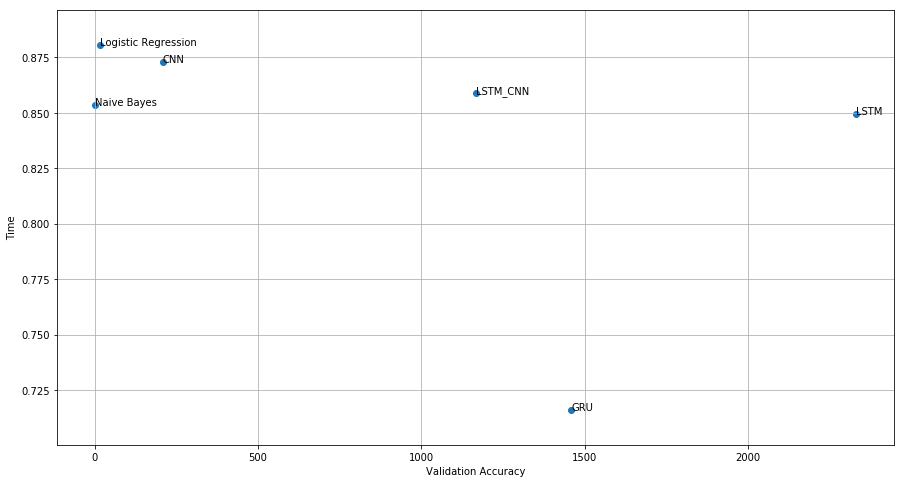

In [117]:
plt.figure(figsize=(15,8))
plt.scatter(validation.time, validation.validation)

for i, txt in enumerate(list(validation.model)):
    plt.annotate(txt, (list(validation.time)[i],validation.validation[i]))
    
plt.xlabel("Validation Accuracy")
plt.ylabel("Time")
plt.grid()
plt.show()

* Logistic regression has the highest accuracy, but naive bayes is more quicker than logistic regression.
* CNN performances better than other neural network models and it's observably quicker than other neural network models.
* Neural network models' performance could be improved by adjusting their parameters and sturcture of hidden layers
* Also, the size of train data is relatively small for neural network and this may be the reason why neural network performance worse here than simple supervised models like logistic regression and naive bayes.